In [5]:
import numpy as np
import pandas as pd
import os

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
%matplotlib inline

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


Text(0, 0.5, 'Number of passengers')

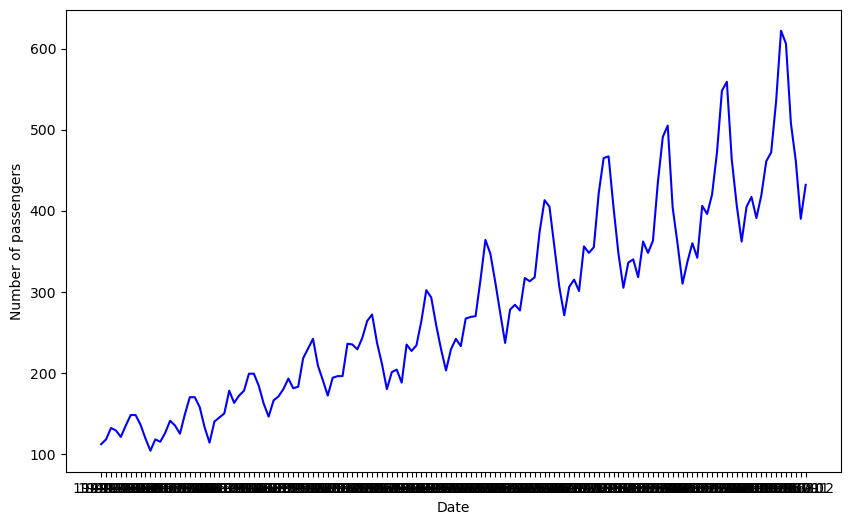

In [9]:
indexedData = data.set_index('Month')
plt.plot(indexedData, color='blue')
plt.xlabel('Date')
plt.ylabel('Number of passengers')

Text(0.5, 1.0, 'Mean')

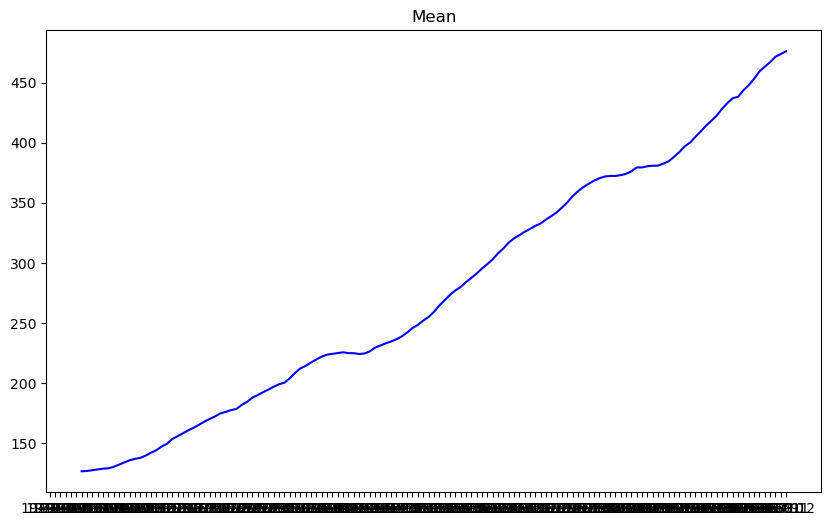

In [10]:
rolmean = indexedData.rolling(window=12).mean()
plt.plot(rolmean, 'blue')
plt.title('Mean')

Text(0.5, 1.0, 'Standard Deviation')

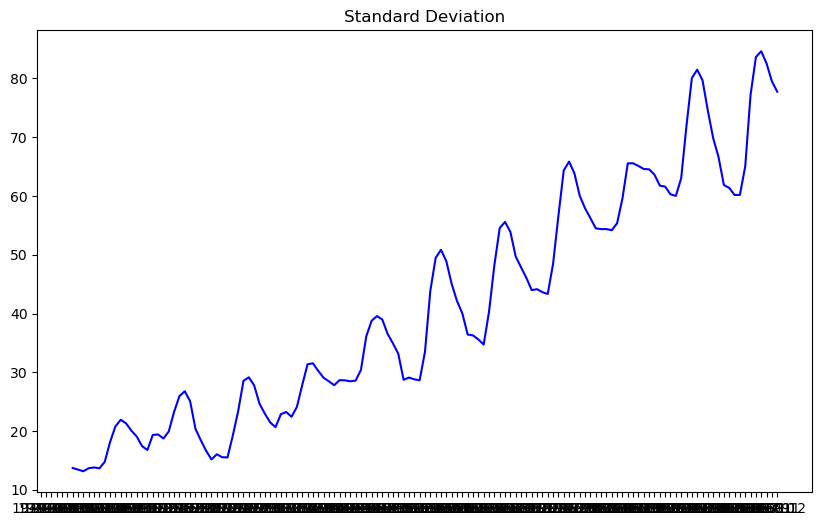

In [11]:
rolstd = indexedData.rolling(window=12).std()
plt.plot(rolstd, 'blue')
plt.title('Standard Deviation')

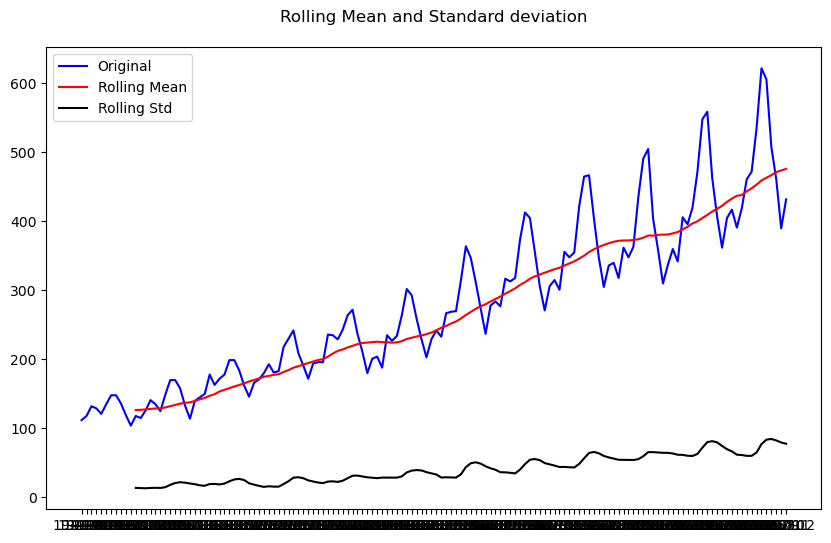

In [12]:
plt.plot(indexedData, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std')

plt.legend(loc='best')
plt.title('Rolling Mean and Standard deviation\n')
# Define the path for saving the file in the Downloads folder
downloads_path = os.path.join(os.path.expanduser("~"), "Downloads", "arima_plot.png")
# Save the plot as a PNG
plt.savefig(downloads_path, format="png")
plt.show()

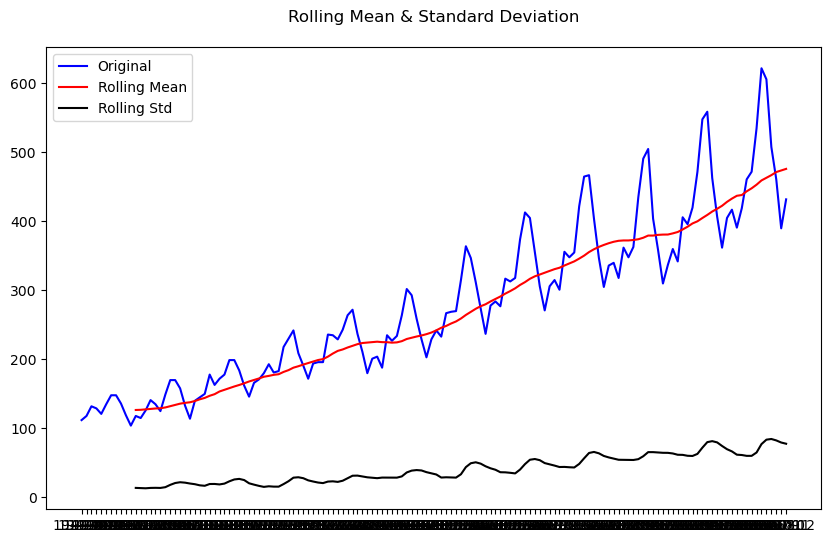

Results of Dickey Fuller Test:

Test Statistic                   0.815369
p-value                          0.991880
No. of Lags used                13.000000
Number of observations used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [13]:
def test_stationary(timeseries):
    
    # Rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    # Plot rolling statistics
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation\n')
    plt.show(block=False)
    
    # Dickey Fuller test
    print('Results of Dickey Fuller Test:\n')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'No. of Lags used', 'Number of observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print(dfoutput)
test_stationary(indexedData)

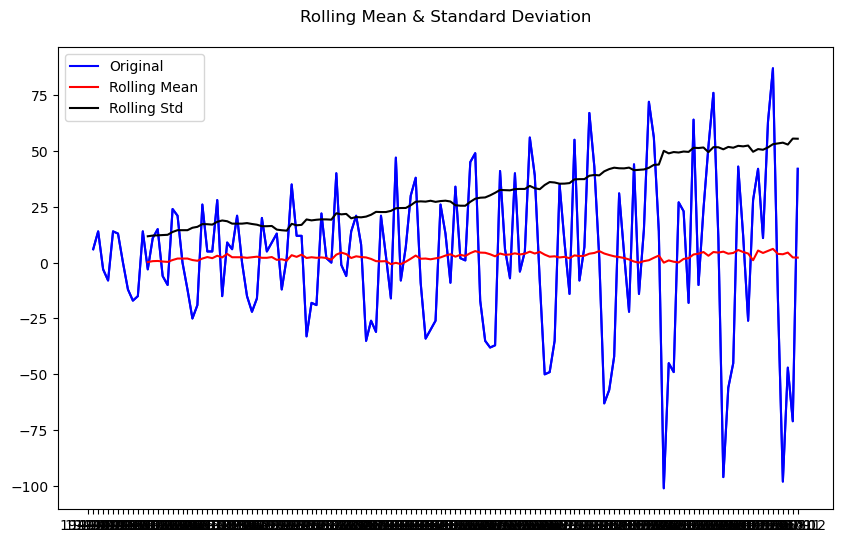

Results of Dickey Fuller Test:

Test Statistic                  -2.829267
p-value                          0.054213
No. of Lags used                12.000000
Number of observations used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


<Figure size 1000x600 with 0 Axes>

In [37]:
dataDiffShifting = indexedData - indexedData.shift()
plt.plot(dataDiffShifting, color='blue')
dataDiffShifting.dropna(inplace=True)
test_stationary(dataDiffShifting)
downloads_path = os.path.join(os.path.expanduser("~"), "Downloads", "arima1_plot.png")
# Save the plot as a PNG
plt.savefig(downloads_path, format="png")
plt.show()

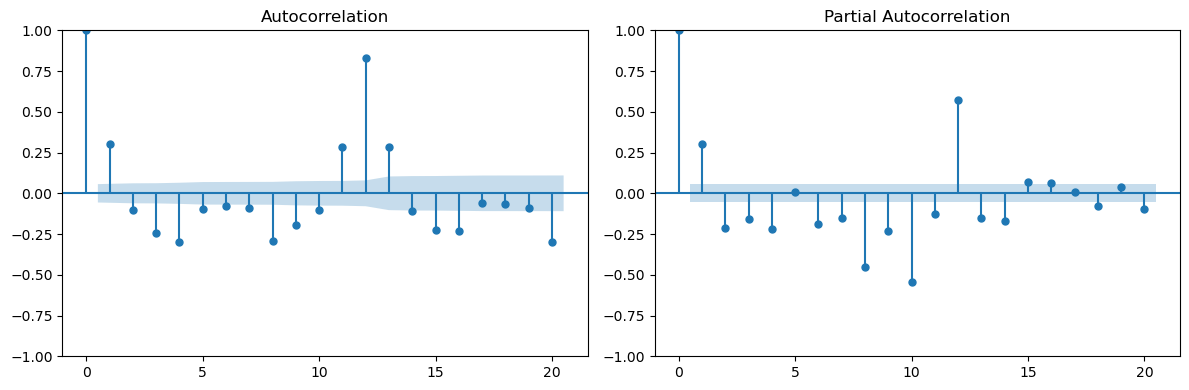

In [38]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
plot_acf(dataDiffShifting, lags=20, ax=axes[0], alpha=0.5)
plot_pacf(dataDiffShifting, lags=20, ax=axes[1], alpha=0.5)
plt.tight_layout()

Plotting ARIMA model


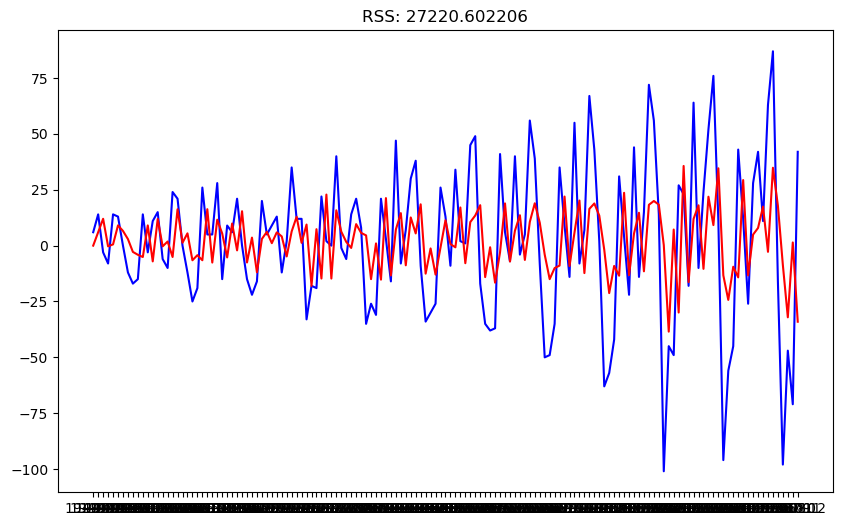

In [39]:
model = ARIMA(dataDiffShifting, order=(2,1,2))
results_ARIMA = model.fit()
plt.plot(dataDiffShifting, color='blue')
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %4f'% sum((results_ARIMA.fittedvalues - dataLogDiffShifting['#Passengers'])**2))
print('Plotting ARIMA model')

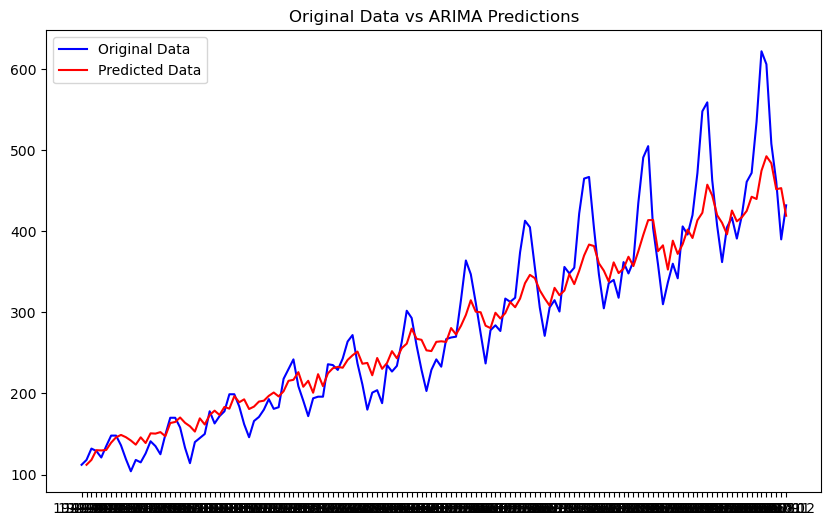

In [36]:
# Get the predicted values
predicted_diff = results_ARIMA.fittedvalues

# Revert differencing to get predictions on the original scale
predicted_original = predicted_diff.cumsum() + indexedData['#Passengers'].iloc[0]

# Plot the original data and predictions
plt.plot(indexedData, color='blue', label='Original Data')
plt.plot(predicted_original, color='red', label='Predicted Data')

# Add title and legend
plt.title('Original Data vs ARIMA Predictions')
plt.legend()
plt.show()

In [41]:
# Ensure the lengths match
original_trimmed = indexedData['#Passengers'].iloc[1:]  # Exclude the first value of the original data
predicted_trimmed = predicted_original.iloc[1:]        # Exclude the first value of the predictions

# Calculate MSE and RMSE
mse = mean_squared_error(original_trimmed, predicted_trimmed)
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


ValueError: Found input variables with inconsistent numbers of samples: [143, 142]